CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed(42)

Define the model class.

In [2]:
# TODO: Enter your code here
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout_prob=0.2):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
from common_utils import split_dataset, preprocess_dataset

# TODO: Enter your code here
def load_csv(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    filename_col = df["filename"]
    lable_col = filename_col.apply(lambda x: x.split(".")[0])
    df["label"] = lable_col
    df.drop(["filename"], axis=1, inplace=True)
    return df

def load_dataframe_split(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df_train, y_train, df_test, y_test = split_dataset(df, ["label"], 0.3, 42)
    df_train, df_test = preprocess_dataset(df_train, df_test)
    return df_train, y_train, df_test, y_test

df = load_csv("./audio_gtzan.csv")

X_train, y_train, X_test, y_test = load_dataframe_split(df)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1400, 57) (1400,) (600, 57) (600,)


> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
# TODO: Enter your code here
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        if self.X.shape[0] != self.y.shape[0]:
            raise ValueError("X and y must have the same length.")
        if self.y.ndim == 1:
            self.y = self.y.reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class AudioDataLoader(DataLoader):
    def __init__(self, dataset, batch_size, shuffle=True):
        super(AudioDataLoader, self).__init__(dataset, batch_size, shuffle=shuffle)
        self.shuffle = shuffle

    def __iter__(self):
        for i in range(0, len(self.dataset), self.batch_size):
            yield self.dataset[i : i + self.batch_size]
            
    def __str__(self):
        dataset_info = f"\tDataset length: {len(self.dataset)}, \n\tDataset shape: {self.dataset[0][0].shape}, \n\tBatch size: {self.batch_size}, \n\tShuffle: {self.shuffle}"
        return f"AudioDataLoader(\n{dataset_info}\n)\n"
            
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

train_loader = AudioDataLoader(train_dataset, 128)
test_loader = AudioDataLoader(test_dataset, 128)

print(train_loader, test_loader)

AudioDataLoader(
	Dataset length: 1400, 
	Dataset shape: torch.Size([57]), 
	Batch size: 128, 
	Shuffle: True
)
 AudioDataLoader(
	Dataset length: 600, 
	Dataset shape: torch.Size([57]), 
	Batch size: 128, 
	Shuffle: True
)



2. Next, define the model, optimizer and loss function.

In [5]:
# TODO: Enter your code here
model = MLP(57)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
from common_utils import EarlyStopper

# TODO: Enter your code here
early_stopper = EarlyStopper(patience=3, min_delta=1e-5)
n_epochs = 100
acc_train = []
acc_test = []
loss_train = []
loss_test = []
f1_train = []
f1_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []


for epoch in range(n_epochs):
    model.train()
    with torch.enable_grad():
        y_pred_list = []
        y_true_list = []
        for batch in train_loader:
            X, y = batch
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred_list.append(y_pred)
            y_true_list.append(y)
        y_pred_list = torch.cat(y_pred_list)
        y_true_list= torch.cat(y_true_list)
        loss_train.append(loss_fn(y_pred_list, y_true_list))
        y_pred_list = torch.round(y_pred_list)
        acc_train.append((y_pred_list == y_true_list).sum().item() / len(y_true_list))
        y_pred_list, y_true_list = y_pred_list.detach().numpy(), y_true_list.detach().numpy()
        f1_train.append(f1_score(y_true_list, y_pred_list))
        precision_train.append(precision_score(y_true_list, y_pred_list))
        recall_train.append(recall_score(y_true_list, y_pred_list))

    model.eval()
    with torch.no_grad():
        y_pred_list = []
        y_true_list = []
        for batch in test_loader:
            X, y = batch
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            y_pred_list.append(y_pred)
            y_true_list.append(y)
        y_pred_list = torch.cat(y_pred_list)
        y_true_list= torch.cat(y_true_list)
        loss_test.append(loss_fn(y_pred_list, y_true_list))
        y_pred_list = torch.round(y_pred_list)
        acc_test.append((y_pred_list == y_true_list).sum().item() / len(y_true_list))
        y_pred_list, y_true_list = y_pred_list.detach().numpy(), y_true_list.detach().numpy()
        f1_test.append(f1_score(y_true_list, y_pred_list))
        precision_test.append(precision_score(y_true_list, y_pred_list))
        recall_test.append(recall_score(y_true_list, y_pred_list))

    log_info = f"epoch: {epoch} \t| train loss: {loss_train[-1]:.5f} \t| test loss: {loss_test[-1]:.5f}"
    print(log_info)

    if early_stopper.early_stop(loss_test[-1]):
        print(f"early stopping at epoch {epoch}")
        break
    
loss_train = torch.tensor(loss_train)
loss_test = torch.tensor(loss_test)

epoch: 0 	| train loss: 0.69534 	| test loss: 0.68477
epoch: 1 	| train loss: 0.68065 	| test loss: 0.66993
epoch: 2 	| train loss: 0.66535 	| test loss: 0.65274
epoch: 3 	| train loss: 0.64601 	| test loss: 0.63107
epoch: 4 	| train loss: 0.62185 	| test loss: 0.60306
epoch: 5 	| train loss: 0.59159 	| test loss: 0.56812
epoch: 6 	| train loss: 0.55488 	| test loss: 0.52708
epoch: 7 	| train loss: 0.51146 	| test loss: 0.48214
epoch: 8 	| train loss: 0.46406 	| test loss: 0.43822
epoch: 9 	| train loss: 0.41859 	| test loss: 0.40012
epoch: 10 	| train loss: 0.38057 	| test loss: 0.36905
epoch: 11 	| train loss: 0.35069 	| test loss: 0.34384
epoch: 12 	| train loss: 0.32686 	| test loss: 0.32253
epoch: 13 	| train loss: 0.30112 	| test loss: 0.30356
epoch: 14 	| train loss: 0.28311 	| test loss: 0.28605
epoch: 15 	| train loss: 0.26028 	| test loss: 0.26985
epoch: 16 	| train loss: 0.24221 	| test loss: 0.25455
epoch: 17 	| train loss: 0.22158 	| test loss: 0.24068
epoch: 18 	| train l

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

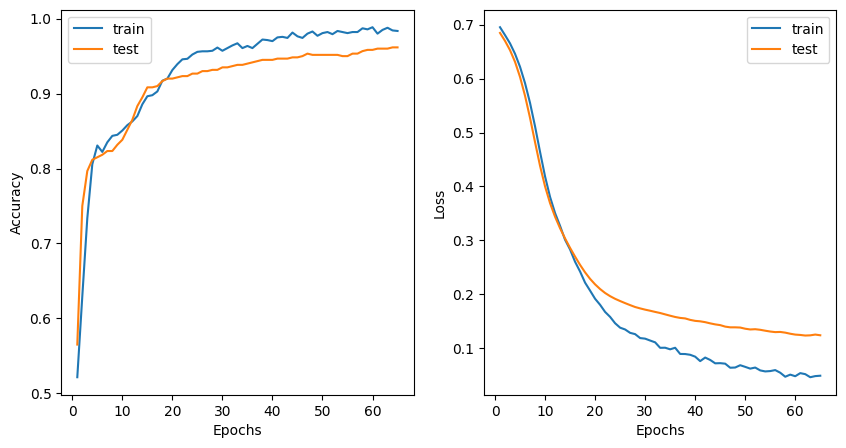

In [7]:
# TODO: Enter your code here

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(acc_train)+1), acc_train, label='train')
plt.plot(range(1, len(acc_test)+1), acc_test, label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(loss_train)+1), loss_train, label='train')
plt.plot(range(1, len(loss_test)+1), loss_test, label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

\# TODO: \<Enter your answer here\>

The train and test accuracy both increase with epochs, with train accuracy being higher than test accuracy. And the train and test loss both decrease with epochs, with train loss being lower than test loss. The model is doing well in fitting the training data, but the test accuracy is not as high as the train accuracy. Hence, the model may be overfitting the training data.

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [8]:
# TODO: Enter your code here

batch_sizes = [32, 64, 128, 256]

model_dict = {batch_size: MLP(57) for batch_size in batch_sizes}

model_dict

{32: MLP(
   (fc1): Linear(in_features=57, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=1, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 64: MLP(
   (fc1): Linear(in_features=57, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=1, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 128: MLP(
   (fc1): Linear(in_features=57, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=1, bias=True)
   (dropout): Dropout(p=0.2, inplace=False)
 ),
 256: MLP(
   (fc1): Linear(in_features=57, out_features=128, bias=True)
   (f

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [9]:
# TODO: Enter your code here

def load_dataframe(df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    X = df.drop(["label"], axis=1).values
    y = df["label"].values
    return X, y

X, y = load_dataframe(df)

X_train_scaled_dict = {batch_size: None for batch_size in batch_sizes}
X_val_scaled_dict = {batch_size: None for batch_size in batch_sizes}
y_train_dict = {batch_size: None for batch_size in batch_sizes}
y_val_dict = {batch_size: None for batch_size in batch_sizes}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for batch_size in batch_sizes:
    X_train_folds = []
    X_val_folds = []
    y_train_folds = []
    y_val_folds = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        scaler = preprocessing.StandardScaler()
        X_train_fold = scaler.fit_transform(X_train_fold)
        X_val_fold = scaler.transform(X_val_fold)

        X_train_folds.append(X_train_fold)
        X_val_folds.append(X_val_fold)
        y_train_folds.append(y_train_fold)
        y_val_folds.append(y_val_fold)

    X_train_scaled_dict[batch_size] = X_train_folds
    X_val_scaled_dict[batch_size] = X_val_folds
    y_train_dict[batch_size] = y_train_folds
    y_val_dict[batch_size] = y_val_folds
    
print(X_train_scaled_dict[32][0].shape, X_val_scaled_dict[32][0].shape, y_train_dict[32][0].shape, y_val_dict[32][0].shape)

(1600, 57) (400, 57) (1600,) (400,)


2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [10]:
# TODO: Enter your code here

time_train_dict = {batch_size: [] for batch_size in batch_sizes}
mean_cv_acc_dict = {batch_size: [] for batch_size in batch_sizes}

for batch_size in batch_sizes:
    model = model_dict[batch_size]
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.BCELoss()

    n_splits = 5        

    for i in range(n_splits):
        X_train_ndarray = X_train_scaled_dict[batch_size][i]
        X_val_ndarray = X_val_scaled_dict[batch_size][i]
        y_train_ndarray = y_train_dict[batch_size][i]
        y_val_ndarray = y_val_dict[batch_size][i]
        train_dataset = AudioDataset(X_train_ndarray, y_train_ndarray)
        val_dataset = AudioDataset(X_val_ndarray, y_val_ndarray)
        train_loader = AudioDataLoader(train_dataset, batch_size)
        val_loader = AudioDataLoader(test_dataset, batch_size)

        loss_train = []
        acc_train = []
        time_train = []
        loss_val = []
        acc_val = []

        early_stopper = EarlyStopper(patience=3, min_delta=1e-5)

        for epoch in range(n_epochs):
            start_time = time.time()
            model.train()
            with torch.enable_grad():
                y_pred_list = []
                y_true_list = []
                for batch in train_loader:
                    X, y = batch
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    y_pred_list.append(y_pred)
                    y_true_list.append(y)
                y_pred_list = torch.cat(y_pred_list)
                y_true_list= torch.cat(y_true_list)
                loss_train.append(loss_fn(y_pred_list, y_true_list))
                y_pred_list = torch.round(y_pred_list)
                acc_train.append((y_pred_list == y_true_list).sum().item() / len(y_true_list))
            end_time = time.time()
            time_train.append(end_time - start_time)

            model.eval()
            with torch.no_grad():
                y_pred_list = []
                y_true_list = []
                for batch in val_loader:
                    X, y = batch
                    y_pred = model(X)
                    loss = loss_fn(y_pred, y)
                    y_pred_list.append(y_pred)
                    y_true_list.append(y)
                y_pred_list = torch.cat(y_pred_list)
                y_true_list= torch.cat(y_true_list)
                loss_val.append(loss_fn(y_pred_list, y_true_list))
                y_pred_list = torch.round(y_pred_list)
                acc_val.append((y_pred_list == y_true_list).sum().item() / len(y_true_list))

            log_info = f"batch_size: {batch_size} \t| epoch: {epoch} \t| train loss: {loss_train[-1]:.5f} \t| test loss: {loss_val[-1]:.5f}\t | time taken: {time_train[-1]}"
            print(log_info)

            if early_stopper.early_stop(loss_val[-1]):
                print(f"early stopping at epoch {epoch}")
                break
            
            if epoch == n_epochs - 1:
                print("reach max number of epoch")

        time_train_dict[batch_size].append(time_train[-1])
        mean_cv_acc_dict[batch_size].append(acc_val[-1])

batch_size: 32 	| epoch: 0 	| train loss: 0.71162 	| test loss: 0.68234	 | time taken: 0.03811788558959961
batch_size: 32 	| epoch: 1 	| train loss: 0.68303 	| test loss: 0.65804	 | time taken: 0.024483203887939453
batch_size: 32 	| epoch: 2 	| train loss: 0.65656 	| test loss: 0.61935	 | time taken: 0.025115013122558594
batch_size: 32 	| epoch: 3 	| train loss: 0.61434 	| test loss: 0.55967	 | time taken: 0.023954153060913086
batch_size: 32 	| epoch: 4 	| train loss: 0.55237 	| test loss: 0.48843	 | time taken: 0.024173974990844727
batch_size: 32 	| epoch: 5 	| train loss: 0.47712 	| test loss: 0.41872	 | time taken: 0.02350902557373047
batch_size: 32 	| epoch: 6 	| train loss: 0.41364 	| test loss: 0.36534	 | time taken: 0.023663997650146484
batch_size: 32 	| epoch: 7 	| train loss: 0.37190 	| test loss: 0.32763	 | time taken: 0.02439713478088379
batch_size: 32 	| epoch: 8 	| train loss: 0.33607 	| test loss: 0.29811	 | time taken: 0.02391672134399414
batch_size: 32 	| epoch: 9 	| tr

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

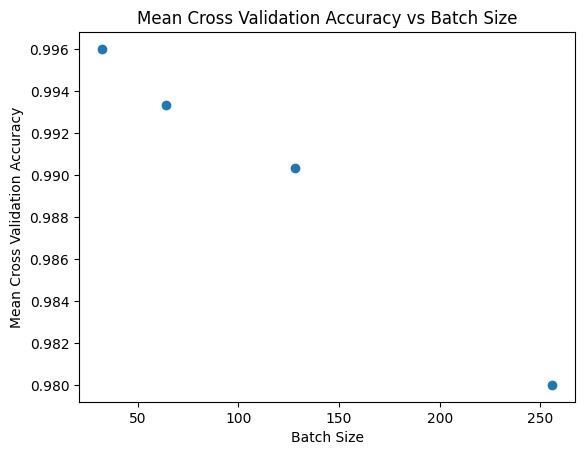

In [11]:
# TODO: Enter your code here

mean_cv_accs_plot = [np.mean(mean_cv_acc_dict[batch_size]) for batch_size in batch_sizes]

plt.scatter(batch_sizes, mean_cv_accs_plot)
plt.xlabel("Batch Size")
plt.ylabel("Mean Cross Validation Accuracy")
plt.title("Mean Cross Validation Accuracy vs Batch Size")
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [12]:
# TODO: Enter your code here

batch_sizes = list(time_train_dict.keys())
split_numbers = [f"Split {i+1}" for i in range(len(time_train_dict[batch_sizes[0]]))]
columns = split_numbers + ["Mean"]

results = pd.DataFrame(index=batch_sizes, columns=columns)

for batch_size in batch_sizes:
    times = time_train_dict[batch_size]
    mean_time = np.mean(times)

    for i, time in enumerate(times):
        results.at[batch_size, f"Split {i+1}"] = time

    results.at[batch_size, "Mean"] = mean_time

print(results)

      Split 1   Split 2   Split 3   Split 4   Split 5      Mean
32   0.023396  0.023439  0.023593  0.023433  0.023148  0.023402
64    0.01429  0.014743  0.014052  0.022999  0.014324  0.016082
128  0.009419  0.009299  0.009438  0.035724   0.00924  0.014624
256  0.032666  0.006501  0.006872  0.007317  0.006396   0.01195


5. Select the optimal batch size and state a reason for your selection.

\# TODO: \<Enter your answer here\>

From the experimental chart, we can see that no matter how the batch size is set, a high cross-validation accuracy can be achieved. It is also worth noting that the cross-validation accuracy tends to decrease as the batch size increases. From the perspective of time consumption, a larger batch size consumes less time. Empirically, doubling the batch size will reduce the time consumption to about three-quarters of the original. Therefore, this is a decision-making problem. If we want the model to train faster, we can choose a larger batch. If we want the model to have better accuracy, we should set a smaller batch. In the scenario of this project, the absolute value of the change in accuracy is not obvious, so we can accept the slight decrease in accuracy caused by a larger batch. Therefore, I will choose a batch size of 128, because it brings faster training time and acceptable accuracy at the same time.

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [ ]:
# TODO: Enter your code here

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [ ]:
# TODO: Enter your code here

2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

In [ ]:
# TODO: Enter your code here

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [ ]:
# TODO: Enter your code here

\# TODO: \<Enter your answer here\>

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [ ]:
# TODO: Enter your code here

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [ ]:
# TODO: Enter your code here

> Install and import shap

In [ ]:
# TODO: Enter your code here

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [ ]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [ ]:
# TODO: Enter your code here
df = 
size_row = 
size_column = 

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [ ]:
# TODO: Enter your code here

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [ ]:
# TODO: Enter your code here

print(pred_label)

> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [ ]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# TODO: Enter your code here

\# TODO: \<Enter your answer here\>